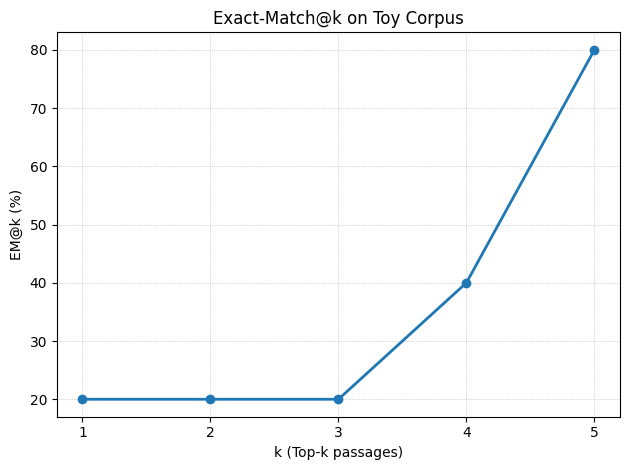

In [ ]:
"""
This module demonstrates a minimal but production‑quality pipeline for
retrieval metrics on a toy corpus:

1. **BM25Retriever** – lightweight BM25 scorer (self‑contained; no external deps).
2. **MetricSuite**     – Exact‑Match@k and token‑level F1.
3. **DemoRunner**      – orchestrates corpus creation, evaluation, and plotting.

You can copy‑paste the whole file into a notebook cell or keep it as a Python
module.  All public APIs have doc‑strings and type hints for IDE autocompletion.
"""

from __future__ import annotations

from dataclasses import dataclass
from typing import List, Sequence, Tuple, Dict, Iterable
from collections import Counter, defaultdict
import math
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# Data containers
# ---------------------------------------------------------------------------

@dataclass(frozen=True)
class QAItem:
    """Container for a single QA pair."""

    question: str
    answer: str


@dataclass
class RetrievalResult:
    """Stores retrieved docs and associated scores for a question."""

    docs: List[str]
    scores: List[float]

# ---------------------------------------------------------------------------
# Retrieval – lightweight BM25 (no third‑party deps, fine for demos)
# ---------------------------------------------------------------------------

class BM25Retriever:
    """A tiny, self‑contained BM25 implementation sufficient for notebooks."""

    # Hyper‑parameters – same defaults used by Okapi BM25
    k1: float = 1.5
    b: float = 0.75

    def __init__(self, corpus: Sequence[str]):
        self.corpus = list(corpus)
        self._tokenised: List[List[str]] = [self._tokenise(doc) for doc in self.corpus]
        self.N = len(self.corpus)
        self.avgdl = sum(len(doc) for doc in self._tokenised) / self.N
        # Pre‑compute document frequencies
        df: Dict[str, int] = defaultdict(int)
        for doc in self._tokenised:
            for term in set(doc):  # unique terms per doc
                df[term] += 1
        self.idf: Dict[str, float] = {
            term: math.log(1 + (self.N - freq + 0.5) / (freq + 0.5)) for term, freq in df.items()
        }

    # ------------------------- public API ---------------------------------
    def retrieve(self, query: str, k: int = 5) -> RetrievalResult:
        """Return top‑k docs and scores for *query*."""
        query_tokens = self._tokenise(query)
        scores = [self._score(query_tokens, doc_tokens, len_doc)
                  for doc_tokens, len_doc in ((d, len(d)) for d in self._tokenised)]
        ranked_idx = np.argsort(scores)[::-1][:k]
        return RetrievalResult(docs=[self.corpus[i] for i in ranked_idx],
                               scores=[scores[i] for i in ranked_idx])

    # ------------------------- internals -----------------------------------
    @staticmethod
    def _tokenise(text: str) -> List[str]:
        return text.lower().split()

    def _score(self, q_tokens: List[str], d_tokens: List[str], dl: int) -> float:
        term_freq: Counter = Counter(d_tokens)
        score = 0.0
        for term in q_tokens:
            if term not in term_freq:
                continue
            df = term_freq[term]
            idf = self.idf.get(term, 0.0)
            denom = df + self.k1 * (1 - self.b + self.b * dl / self.avgdl)
            score += idf * df * (self.k1 + 1) / denom
        return score

# ---------------------------------------------------------------------------
# Metrics
# ---------------------------------------------------------------------------

class MetricSuite:
    """Collection of retrieval & answer metrics suitable for dashboards."""

    @staticmethod
    def em_at_k(results: List[RetrievalResult], gold: Sequence[QAItem], k: int) -> float:
        """Exact‑Match @k: fraction of questions whose *gold answer text* appears
        in the top‑k retrieved docs."""
        hits = 0
        for i, qa in enumerate(gold):
            gold_lower = qa.answer.lower()
            if any(gold_lower in doc.lower() for doc in results[i].docs[:k]):
                hits += 1
        return hits / len(gold)

    @staticmethod
    def token_f1(pred: str, gold: str) -> float:
        pred_t = pred.lower().split()
        gold_t = gold.lower().split()
        common = Counter(pred_t) & Counter(gold_t)
        if not common:
            return 0.0
        precision = sum(common.values()) / len(pred_t)
        recall = sum(common.values()) / len(gold_t)
        return 2 * precision * recall / (precision + recall)

# ---------------------------------------------------------------------------
# Demo orchestration
# ---------------------------------------------------------------------------

class DemoRunner:
    """One‑stop shop: build corpus ⇒ retrieve ⇒ score ⇒ plot."""

    def __init__(self) -> None:
        self.corpus: List[str] = [
            "Dhaka stands out as a major economic and cultural hub in South Asia.",
            "Chittagong, while not the capital, is a crucial port city in Bangladesh.",
            "Moscow has been the heart of Russian politics and culture for centuries.",
            "Saint Petersburg was once the capital of Russia and remains a cultural icon.",
            "Guido van Rossum contributed to several programming languages during his career.",
            "Python, known for its readable syntax, was introduced in the early 1990s.",
            "Bangladesh is bordered by India and Myanmar and has a dense river network.",
            "Many Russian citizens use the Cyrillic alphabet in daily writing.",
            "Python is widely used in AI, data analysis, and scientific computing.",
            "The Ganges Delta is a defining geographic feature of Bangladesh."
          ]


        self.qa_set: List[QAItem] = [
            QAItem("Which city is the capital of Bangladesh?", "Dhaka"),
            QAItem("What writing system is commonly used in Russia?", "Cyrillic"),
            QAItem("Who is the creator of the Python programming language?", "Guido van Rossum"),
            QAItem("Which Asian country is surrounded by India and Myanmar?", "Bangladesh"),
            QAItem("In which city is the political center of Russia located?", "Moscow"),
          ]


        self.retriever = BM25Retriever(self.corpus)

    # ------------------------- workflow ------------------------------------
    def run_retrieval(self, k: int = 5) -> List[RetrievalResult]:
        """Retrieve top‑*k* docs for every question."""
        return [self.retriever.retrieve(q.question, k) for q in self.qa_set]

    def evaluate(self, k_values: Iterable[int] = range(1, 6)) -> Tuple[List[int], List[float]]:
        """Return (k_list, EM@k_list)."""
        em_scores: List[float] = []
        cached_top_k = self.run_retrieval(max(k_values))
        for k in k_values:
            em = MetricSuite.em_at_k(cached_top_k, self.qa_set, k)
            em_scores.append(em)
        return list(k_values), em_scores

    def plot_em_curve(self, k_values: Iterable[int] = range(1, 6)) -> None:
        k_list, em_scores = self.evaluate(k_values)
        plt.figure()
        plt.plot(k_list, [s * 100 for s in em_scores], marker="o", linewidth=2)
        plt.xticks(k_list)
        plt.ylabel("EM@k (%)")
        plt.xlabel("k (Top‑k passages)")
        plt.title("Exact‑Match@k on Toy Corpus")
        plt.grid(True, linestyle=":", linewidth=0.5)
        plt.tight_layout()
        plt.show()


# ---------------------------------------------------------------------------
# Script entry point
# ---------------------------------------------------------------------------

def main():  # pragma: no cover – for quick demo usage
    demo = DemoRunner()
    demo.plot_em_curve()


if __name__ == "__main__":
    main()
